TensorFlow version: 2.19.0
Train set: (60000, 28, 28, 1) (60000,)
Test set: (10000, 28, 28, 1) (10000,)

=== Training CNN with 3x3 kernel ===
Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.8843 - loss: 0.4012 - val_accuracy: 0.9800 - val_loss: 0.0763
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.9772 - loss: 0.0779 - val_accuracy: 0.9828 - val_loss: 0.0664
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.9841 - loss: 0.0517 - val_accuracy: 0.9870 - val_loss: 0.0514
Test Accuracy for 3x3 kernel: 0.9820

=== Training CNN with 5x5 kernel ===
Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.8852 - loss: 0.4033 - val_accuracy: 0.9830 - val_loss: 0.0639
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.9826 - loss: 0.0599 - val_accuracy: 0.9838 - val_loss: 0.0532
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9866 - loss: 0.0432 - val_accuracy: 0.9870 - val_loss: 0.0467
Test Accu

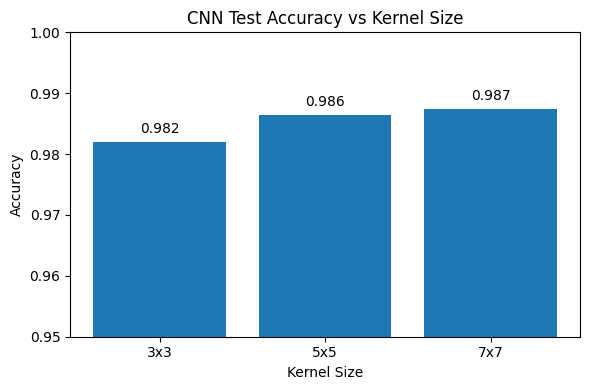


[Filters] Visualizing 3x3 


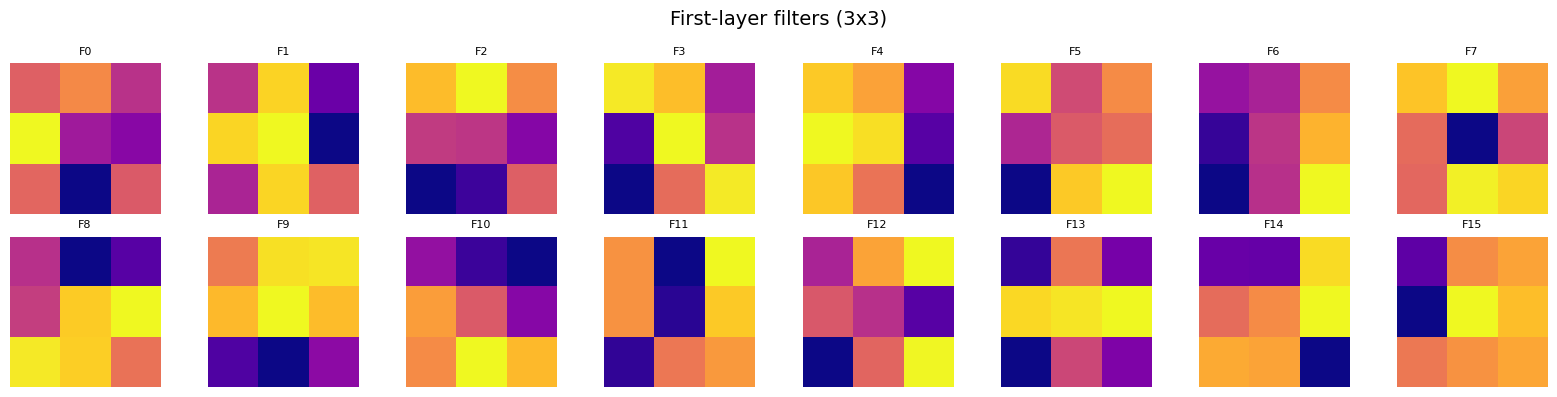


[Filters] Visualizing 5x5 


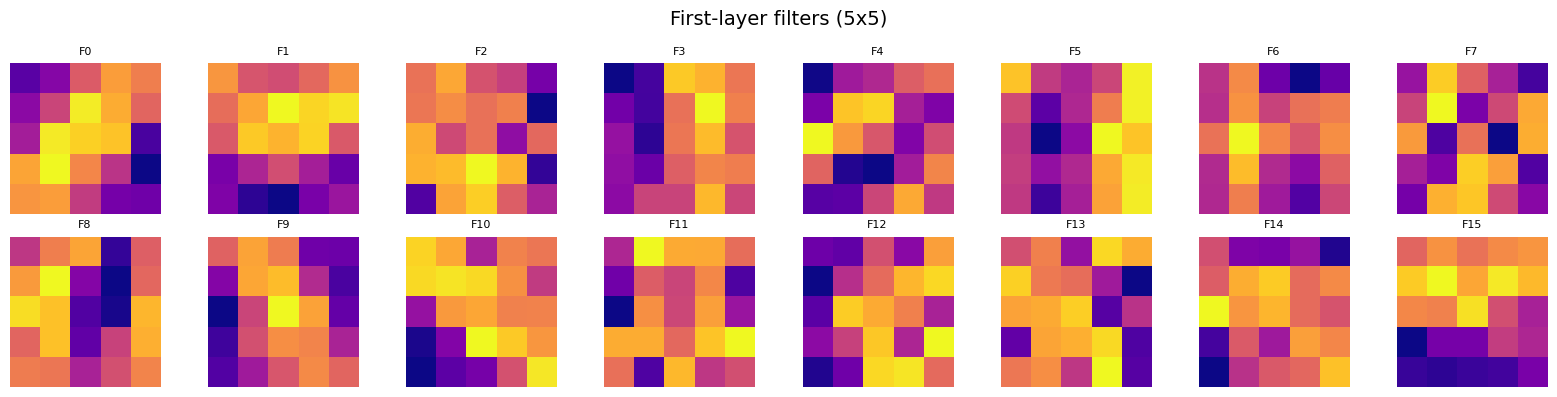


[Filters] Visualizing 7x7 


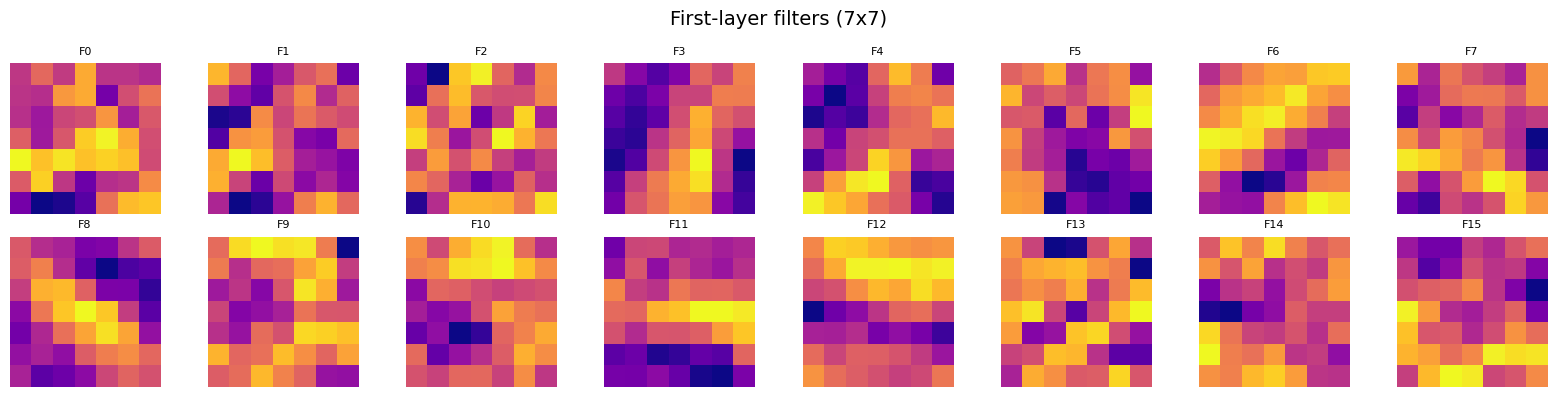

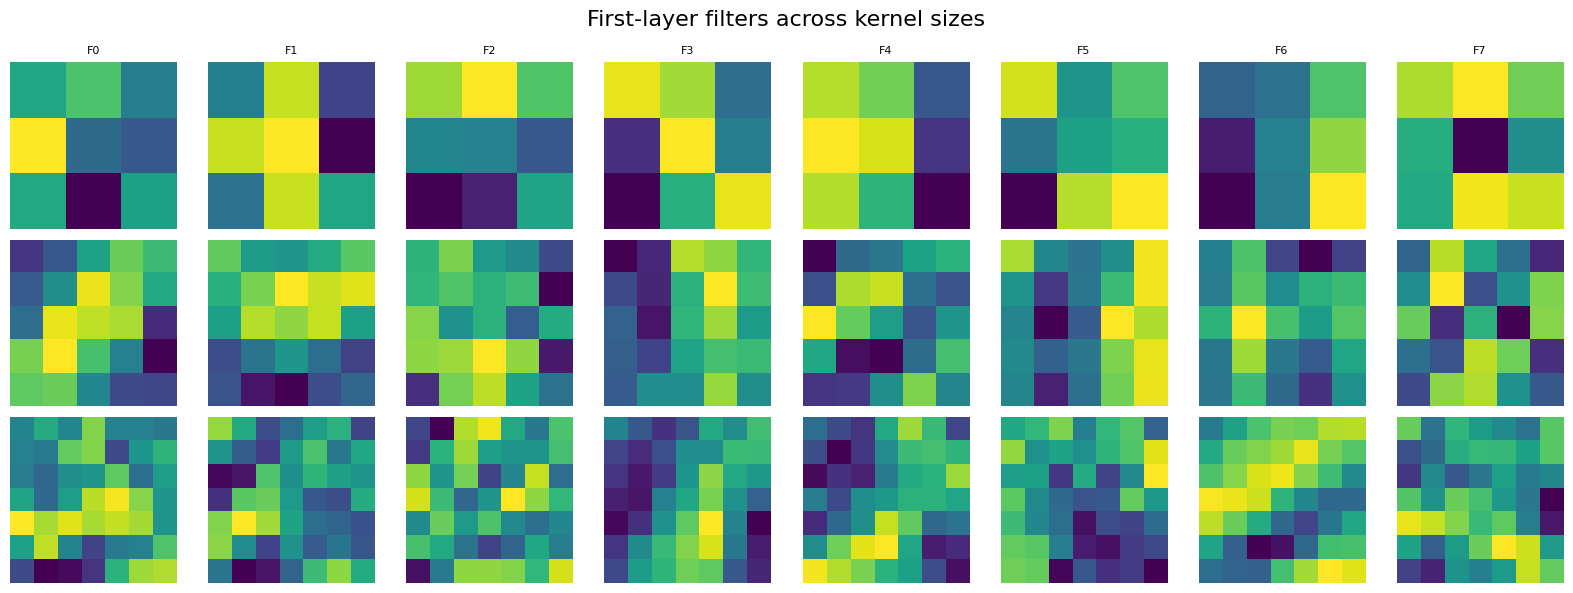

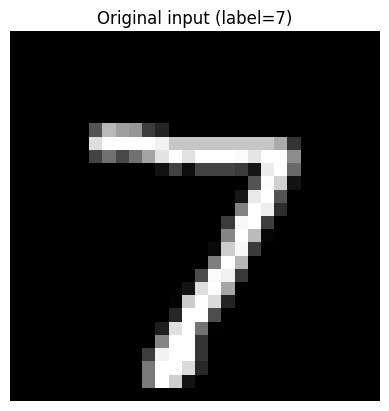


[Feature maps] kernel=3x3, showing 8 maps


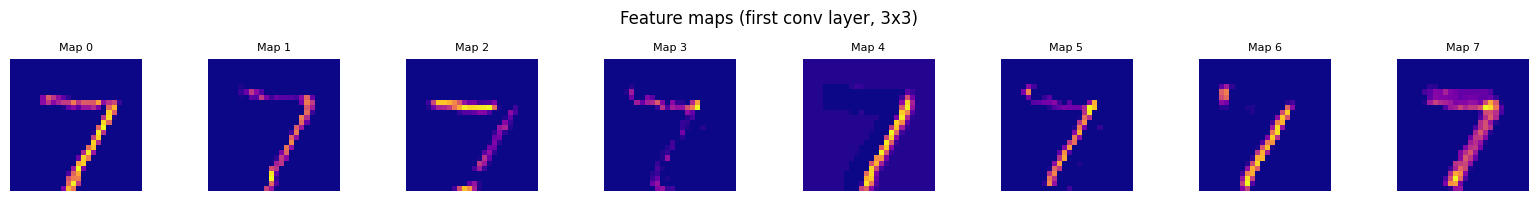


[Feature maps] kernel=5x5, showing 8 maps


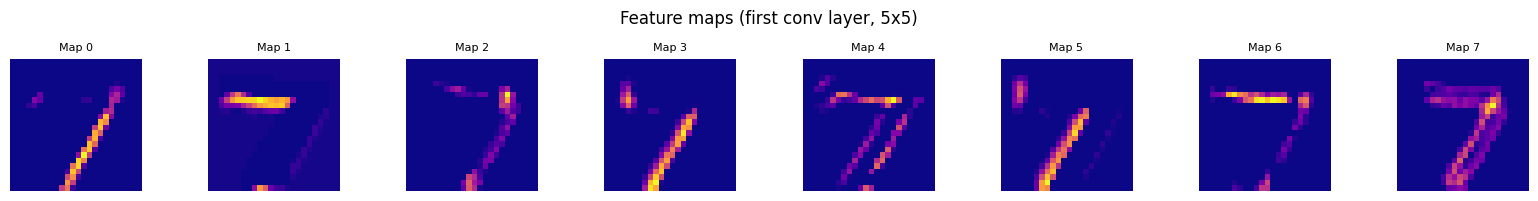


[Feature maps] kernel=7x7, showing 8 maps


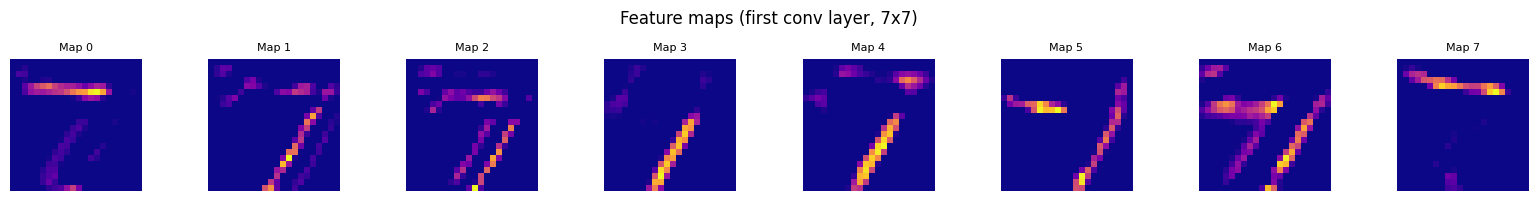

In [2]:

# CNN Kernel Size Comparison + Visualisations
# TensorFlow / Keras, MNIST


import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow version:", tf.__version__)


# 1. Load & preprocess MNIST

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize & reshape for CNN: (N, 28, 28, 1)
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

print("Train set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)


# 2. Build CNN with variable kernel size

def build_cnn(kernel_size):
    model = models.Sequential([
        layers.Conv2D(
            32,
            kernel_size=kernel_size,
            activation="relu",
            input_shape=(28, 28, 1),
            name=f"conv2d_{kernel_size[0]}x{kernel_size[1]}"
        ),
        layers.MaxPooling2D(2, 2, name="maxpool_1"),
        layers.Flatten(name="flatten"),
        layers.Dense(64, activation="relu", name="dense_64"),
        layers.Dense(10, activation="softmax", name="output")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# 3. Train models for 3x3, 5x5, 7x7

kernels = [3, 5, 7]
models_dict = {}

for k in kernels:
    print(f"\n=== Training CNN with {k}x{k} kernel ===")
    model = build_cnn((k, k))
    history = model.fit(
        x_train,
        y_train,
        epochs=3, # increase if you want better accuracy
        batch_size=64,
        validation_split=0.1,
        verbose=1
    )
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    models_dict[k] = {
        "model": model,
        "history": history,
        "test_acc": test_acc
    }
    print(f"Test Accuracy for {k}x{k} kernel: {test_acc:.4f}")


# 4. Bar plot: accuracy vs kernel size

plt.figure(figsize=(6, 4))
accs = [models_dict[k]["test_acc"] for k in kernels]
labels = [f"{k}x{k}" for k in kernels]
plt.bar(labels, accs)
plt.ylim(0.95, 1.0)  # adjust if needed
plt.title("CNN Test Accuracy vs Kernel Size")
plt.ylabel("Accuracy")
plt.xlabel("Kernel Size")
for i, v in enumerate(accs):
    plt.text(i, v + 0.001, f"{v:.3f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


# 5. Visualise first-layer filters (colormap version)

def visualize_filters_colormap(model, kernel_size, cmap="viridis", max_filters=32):
    """
    Visualize first conv layer filters using a matplotlib colormap.
    Works with 1-channel or multi-channel inputs.
    """
    filters, biases = model.layers[0].get_weights()
    print(f"\n[Filters] Visualizing {kernel_size}x{kernel_size} ")

    # filters shape: (kh, kw, in_channels, n_filters)
    kh, kw, in_ch, n_filters = filters.shape

    # Limit number of filters displayed
    n_show = min(n_filters, max_filters)

    # Normalize filters globally for better contrast
    f_min, f_max = filters.min(), filters.max()
    filters_norm = (filters - f_min) / (f_max - f_min + 1e-8)

    cols = 8
    rows = int(np.ceil(n_show / cols))
    plt.figure(figsize=(2 * cols, 2 * rows))

    for i in range(n_show):
        ax = plt.subplot(rows, cols, i + 1)

        # For 1-channel filters (e.g. MNIST): take [:,:,0]
        if in_ch == 1:
            f_img = filters_norm[:, :, 0, i]
        else:
            # For multi-channel, take norm across channels
            f_img = np.linalg.norm(filters_norm[:, :, :, i], axis=-1)

        ax.imshow(f_img, cmap=cmap)
        ax.set_title(f"F{i}", fontsize=8)
        ax.axis("off")

    plt.suptitle(f"First-layer filters ({kernel_size}x{kernel_size})", fontsize=14)
    plt.tight_layout()
    plt.show()

# Example: show filters for each kernel size
for k in kernels:
    model = models_dict[k]["model"]
    visualize_filters_colormap(model, k, cmap="plasma", max_filters=16)


# 6. Side-by-side filter comparison across kernel sizes

def compare_filters_across_kernels(models_dict, kernels=[3, 5, 7], cmap="viridis", max_filters=8):
    """
    Show first conv filters side-by-side for different kernel sizes.
    Each row: one kernel size
    Each column: filter index
    """
    filters_dict = {}
    for k in kernels:
        model = models_dict[k]["model"]
        filters, _ = model.layers[0].get_weights()
        f_min, f_max = filters.min(), filters.max()
        filters_dict[k] = (filters - f_min) / (f_max - f_min + 1e-8)

    cols = max_filters
    rows = len(kernels)
    plt.figure(figsize=(2 * cols, 2 * rows))

    for row_idx, k in enumerate(kernels):
        filters_norm = filters_dict[k]
        kh, kw, in_ch, n_filters = filters_norm.shape
        n_show = min(max_filters, n_filters)

        for i in range(n_show):
            ax = plt.subplot(rows, cols, row_idx * cols + i + 1)
            if in_ch == 1:
                f_img = filters_norm[:, :, 0, i]
            else:
                f_img = np.linalg.norm(filters_norm[:, :, :, i], axis=-1)

            ax.imshow(f_img, cmap=cmap)
            if row_idx == 0:
                ax.set_title(f"F{i}", fontsize=8)
            if i == 0:
                ax.set_ylabel(f"{k}x{k}", fontsize=10)
            ax.axis("off")

    plt.suptitle("First-layer filters across kernel sizes", fontsize=16)
    plt.tight_layout()
    plt.show()

compare_filters_across_kernels(models_dict, kernels=kernels, cmap="viridis", max_filters=8)


# 7. Feature map visualisation (what filters "see")

def visualize_feature_maps(model, x_sample, kernel_size, max_maps=8, cmap="plasma"):
    """
    Visualize feature maps (activations) from the first conv layer
    for one input image x_sample (shape: (28, 28, 1)).
    This version does NOT rely on model.input, so it works even if
    the model hasn't been used in a functional graph yet.
    """
    # First conv layer
    first_conv_layer = model.layers[0]

    # Add batch dimension and convert to tensor
    x_input = np.expand_dims(x_sample, axis=0)          # (1, 28, 28, 1)
    x_input_tf = tf.convert_to_tensor(x_input)

    # Forward pass through only the first conv layer
    feature_maps = first_conv_layer(x_input_tf)         # shape: (1, H, W, C)
    feature_maps = feature_maps.numpy()[0]              # (H, W, C)

    H, W, C = feature_maps.shape
    n_show = min(C, max_maps)

    print(f"\n[Feature maps] kernel={kernel_size}x{kernel_size}, showing {n_show} maps")

    cols = n_show
    rows = 1
    plt.figure(figsize=(2 * cols, 2 * rows))

    for i in range(n_show):
        ax = plt.subplot(rows, cols, i + 1)
        fmap = feature_maps[:, :, i]
        fm_min, fm_max = fmap.min(), fmap.max()
        fmap_norm = (fmap - fm_min) / (fm_max - fm_min + 1e-8)
        ax.imshow(fmap_norm, cmap=cmap)
        ax.set_title(f"Map {i}", fontsize=8)
        ax.axis("off")

    plt.suptitle(f"Feature maps (first conv layer, {kernel_size}x{kernel_size})", fontsize=12)
    plt.tight_layout()
    plt.show()

# Pick a test image to visualise feature maps
idx = 0
x_sample = x_test[idx]  # (28, 28, 1)
y_sample = y_test[idx]

plt.figure()
plt.imshow(x_sample.squeeze(), cmap="gray")
plt.title(f"Original input (label={y_sample})")
plt.axis("off")
plt.show()

# Visualise feature maps for each kernel size
for k in kernels:
    model = models_dict[k]["model"]
    visualize_feature_maps(model, x_sample, kernel_size=k, max_maps=8, cmap="plasma")


GitHub Repository link:


https://github.com/ShanmughavelS/Machine_Learning